# 对比性测试

## 导入

In [1]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

JuNarsese v1.3.4


JuNarsese v1.3.4


In [2]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [3]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 2


3

In [4]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [5]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

function randomSentence(depth=3, width=3)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(randomStatement(depth-1, width))
end

function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 <<<<dakt <-> #zt> <=> <?xvdkdbru --> ^zbboakb>> ==> <<$kza <-> ^tpxozepa> ==> <$d --> fxlbzfiztd>>> ==> <<$huumwh --> ^k> ==> <#tclouvenhp --> ?qye>>>@
 <(-, ndijfyylxo, #ya) <-> #fyhktjfxd>?
 <(\, dqzlf, ^lbtnrjzwzv, _, $qelssdz, ^gztpycnk) <-> ^kwezisdhj>. %1.0;0.5%
 <<<<^ghey --> ?nsdunno> <=> <$zdiiit --> ^cazngqaep>> ==> <jluxxo <-> ^mvfjrplc>> <=> <(\, $ljoijtmimj, _, ^untuv, ?ajcxvsqgrl, #hsc) <-> ^iei>>@
 <(-, tauac, ^yhw) <-> ^hfba>
 (\, _, <<cadzmy --> #ovdtiomrnt> ==> <^acsmxsq <-> xzucmzzjw>>)
 <{#dutxxnt} <-> $nbzom>@
 (--, <<<^fiptkkbd --> ^z> <=> <?iox --> $jcmswzdgd>> <=> <<<gsuuw <-> #vu> <=> <$qsadiqo --> ^rmdfptap>> ==> <<?rhbxhh --> l> ==> <$lovbcu <-> $wfun>>>>)
 <<(-, #hzelt, #vfpkn) <-> $koivjkd> <=> <(-, ^rgjwuclyo, ?txchvhamyy) --> ?ghsbapz>>@
 <<(|, ?nnbahvqd, #pk, ^vee) <-> #d> ==> <^hfnsxz --> {#r}>>@

生成测试集

In [6]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 对「语句」的支持欠佳：Junars无法解析，获取语法复杂度方面存在欠缺
    for _ in 1:N
]

randomNarsese(D, W) = (--, <psbbcpnhmf --> (-, <<tzixmphcd --> $jjehab> ==> <$uhkcfrbk --> ?bezyh>>, (\, _, (/, ^wnaidj, ?xzeq, _), <<^er <-> ^skymhl> <=> <#vdkelpz --> #aacvosaj>>, <?lhkxkerhez <-> ?pjbprejan>))>)

500-element Vector{AbstractTerm}:
 (--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)
 (&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)
 (--, <iyrzo --> ^euoe>)
 (/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <

## 评估函数

#### 导入数据分析工具：DataFrames

In [7]:
using DataFrames

测试：使用具名元组直接添加行

In [8]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


#### 构造测试用表

In [9]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

Row,original_term,string
,Abstract…,String
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)"
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)"
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)"
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))"
5,"(\\, _, (--, <<(-, ^kifq, $qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> $dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, $xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> $v> ==> <<$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> $igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <$kqznj <-> $wqlfuwm>, {^dzogpmt, $odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> $udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, $seuut, $wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, (&, $fplxsm, $hkepw, $mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <$m --> $hdo>), (-, $xzpsgbn, #ygjcjm), <#rlmb --> ^dwg>, (~, iqfc, ^qhjmkolmdv), (--, <<$hiwyiywy --> ^vxu> ==> <#qsifs <-> ^topnahq>>), [?cdzix, #cl, $dirktun, ^ror, skaxze, tmwknas, #v, #xtbzun], (/, $zyvuxfcye, _)), (\\, _, (~, qwpvhdwuvs, ^mxfynb), {btuvblso, buu, $f, ^keyvuttqb, #nl, $qs, ?sfjaj, #vbflju, $vskjghro, ^vxss}, (--, <hyv

In [10]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",19
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",35
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)",4
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))",82
5,"(\\, _, (--, <<(-, ^kifq, $qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> $dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, $xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> $v> ==> <<$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> $igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <$kqznj <-> $wqlfuwm>, {^dzogpmt, $odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> $udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, $seuut, $wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, (&, $fplxsm, $hkepw, $mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <$m --> $hdo>), (-, $xzpsgbn, #ygjcjm), <#rlmb --> ^dwg>, (~, iqfc, ^qhjmkolmdv), (--, <<$hiwyiywy --> ^vxu> ==> <#qsifs <-> ^topnahq>>), [?cdzix, #cl, $dirktun, ^ror, skaxze, tmwknas, #v, #xtbzun], (/, $zyvuxfcye, _)), (\\, _, (~, qwpvhdwuvs, ^mxfynb), {btuvblso, buu, $f, ^keyvuttqb, #nl, $qs, ?sfjaj, #vbflju, 

#### 增加「特殊语法」：更能体现出解析器通用性的语法

1. 无连接符复合词项⇒乘积：`(A, B)`⇔`(*, A, B)`

In [11]:
# 无连接符复合词项⇒乘积 #
# 📝直接使用「布尔索引」对切片进行操作

# 使用 map() 函数对 test_set_extra1 中的 string 列进行操作，返回一个新数据表
# 将其中符合正则表达式 r"\(\*\W*," 的字符串替换为 "(*,"
test_set_extra1_string = map(test_set.string) do x
    replace(x, r"\(\*\W*," => "(*,")
end

# 使用「布尔索引」来选择不等于原始 string 列的值
# 并将这些值替换为经过操作后的新值
# 注意：.≠ 运算符用于逐元素比较两个数组，生成一个布尔型数组
# test_set_extra1.string[test_set_extra1! .≠ test_set_extra1.string] = test_set_extra1![test_set_extra1! .≠ test_set_extra1.string]

#【20230819 20:07:04】现在直接把「能改成新格式」的数据增加到主数据集中
indices = test_set_extra1_string .≠ test_set.string # 索引：只获取「会被改变的词项」

test_set_extra1 = test_set[indices, :] |> deepcopy

test_set_extra1.string = test_set_extra1_string[indices]

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra1
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",19
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",35
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)",4
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))",82
5,"(\\, _, (--, <<(-, ^kifq, $qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> $dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, $xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> $v> ==> <<$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> $igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <$kqznj <-> $wqlfuwm>, {^dzogpmt, $odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> $udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, $seuut, $wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, (&, $fplxsm, $hkepw, $mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <$m --> $hdo>), (-, $xzpsgbn, #ygjcjm), <#rlmb --> ^dwg>, (~, iqfc, ^qhjmkolmdv), (--, <<$hiwyiywy --> ^vxu> ==> <#qsifs <-> ^topnahq>>), [?cdzix, #cl, $dirktun, ^ror, skaxze, tmwknas, #v, #xtbzun], (/, $zyvuxfcye, _)), (\\, _, (~, qwpvhdwuvs, ^mxfynb), {btuvblso, buu, $f, ^keyvuttqb, #nl, $qs, ?sfjaj, #vbflju, 

2. 随机添加空白字符：空格` `、换行`\r`、回车`\n`、换页`\f`、水平制表符`\t`、垂直制表符`\v`

In [12]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",19
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",35
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)",4
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))",82
5,"(\\, _, (--, <<(-, ^kifq, $qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> $dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, $xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> $v> ==> <<$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> $igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <$kqznj <-> $wqlfuwm>, {^dzogpmt, $odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> $udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, $seuut, $wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, (&, $fplxsm, $hkepw, $mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <$m --> $hdo>), (-, $xzpsgbn, #ygjcjm), <#rlmb --> ^dwg>, (~, iqfc, ^qhjmkolmdv), (--, <<$hiwyiywy --> ^vxu> ==> <#qsifs <-> ^topnahq>>), [?cdzix, #cl, $dirktun, ^ror, skaxze, tmwknas, #v, #xtbzun], (/, $zyvuxfcye, _)), (\\, _, (~, qwpvhdwuvs, ^mxfynb), {btuvblso, buu, $f, ^keyvuttqb, #nl, $qs, ?sfjaj, #vbflju, 

#### 构造评估函数

In [13]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "$(parser)：以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [14]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Abstract…,String,Int64,Any,Float64?,Exception?
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",19,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",0.514139,missing
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",35,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",0.168078,missing
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)",4,"(--, <iyrzo --> ^euoe>)",0.0002821,missing
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))",82,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $

In [15]:
# 导入OpenJunars
isdefined(Main, :Junars) || begin
    push!(LOAD_PATH, "../../../OpenJunars/")
    import Junars
end
# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
@info "OpenJunars解析结果:" parsed_term typeof(parsed_term)

┌ Info: OpenJunars解析结果:
│   parsed_term = "<A-->B>"
│   typeof(parsed_term) = Junars.Gene.Inheritance
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\comparative_tests.ipynb:9


In [16]:
testParser!(Junars.parse_term, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Abstract…,String,Int64,Any,Float64?,Exception?
1,"(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)","(--, <(~, <<$sawgouj <-> #w> <=> <<$qdfnbmrgx <-> $wtfxzk> <=> <^vr --> $zwfx>>>, <<<^neg --> ?pusnbvgprz> ==> <^a --> #pj>> <=> <ad <-> glxdol>>) --> ^bfgmbiffjg>)",19,"""(¬,<(~,<<#w<->\\$sawgouj><=><<\\$qdfnbmrgx<->\\$wtfxzk><=><^vr-->\\$zwfx>>>,<<<^neg-->?pusnbvgprz>==><^a-->#pj>><=><ad<->glxdol>>)-->^bfgmbiffjg>)""",0.553578,missing
2,"(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)","(&, (-, <<<$h <-> #khulk> <=> <^xgpu --> chxdvit>> <=> <lwxjr --> ?f>>, <(|, #oihognngbc, ?sjzw) --> (*, #vo, dxscl, $httxwdvp)>), <<<(-, tbi, ^kox) <-> ?kdtf> ==> <?vfglpc <-> ^xeputrui>> <=> <<$uhpsszpu <-> (\\, qeuaaxtu, _)> ==> <<<#mwbslcqmqn --> dihnvqxjol> <=> <?rvqi <-> ^zqgyfyhxvo>> ==> <^fsnjksnfku <-> ^wiizxvfru>>>>)",35,"""(&,(-,<<<#khulk<->\\$h><=><^xgpu-->chxdvit>><=><lwxjr-->?f>>,<(|,#oihognngbc,?sjzw)-->(*,#vo,dxscl,\\$httxwdvp)>),<<(&&,<\\$uhpsszpu<->(\\\\,qeuaaxtu,_)>,<<#mwbslcqmqn-->dihnvqxjol><=><?rvqi<->^zqgyfyhxvo>>)==><^fsnjksnfku<->^wiizxvfru>><=><<(-,tbi,^kox)<->?kdtf>==><?vfglpc<->^xeputrui>>>)""",0.758694,missing
3,"(--, <iyrzo --> ^euoe>)","(--, <iyrzo --> ^euoe>)",4,"""(¬,<iyrzo-->^euoe>)""",2.64e-5,missing
4,"(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))","(/, (--, <<(~, ?s, mp) <-> ?m> ==> <<(*, #oveztt, ?rohy, $kqnuicql, #wdo, $pjk) --> (|, ^mr, p, wrayumxj)> <=> <<$fx --> #ygz> <=> <hkmqtag <-> ^plcnfgqq>>>>), <<$rkgm <-> ^vqbze> <=> <<<$yzugbpyq --> #zlkawnkr> ==> <?zlywmstya --> ^qnqi>> ==> <<$tfwekgpjv --> izysvwq> ==> <<?kqahksxltg <-> $unxig> ==> <^q <-> ?ytddfhb>>>>>, <<(~, $gmigue, ?y) <-> (-, vfhc, ^pqqktkvv)> ==> <[#avmredcg, ?dtfdtolwn, ?e, $eibpuhamd] <-> rztphv>>, (-, (-, (--, <#f <-> ^qwmuxuipof>), (\\, $rcdjiav, _, #gaiwnhmlbb)), (-, {htpuwcgow, $ixkabsqr, $n}, (--, <#zc --> thev>))), (|, (--, <<<fcup <-> $przxv> <=> <?idbtpqqnu <-> yumaddxd>> <=> <<$oztucvv <-> #xbvgplzh> ==> <^dxgcnretou <-> ^tfmmwnilxi>>>)), _, (--, <<?qpbzbl --> (\\, _, gimyd, #fy, #tcgmabyy, sn)> ==> <<<^hob --> #xoejlt> <=> <^i <-> #jihnl>> ==> <<?hfn --> #gclbfesp> ==> <?w --> $g>>>>))",82,"""(/,(¬,<<(~,?s,mp)<->?m>==><<(*,#oveztt,?rohy,\\$kqnuicql,#wdo,\\$pjk)-->(|,^mr,p,wrayumxj)><=><<\\$fx-->#ygz><=><^plcnfgqq<->hkmqtag>>>>),<<\\$rkgm<->^vqbze><=><(&&,(&&,<\\$tfwekgpjv-->izysvwq>,<\\$unxig<->?kqahksxltg>),<<\\$yzugbpyq-->#zlkawnkr>==><?zlywmstya-->^qnqi>>)==><?ytddfhb<->^q>>>,<<(-,vfhc,^pqqktkvv)<->(~,\\$gmigue,?y)>==><[#avmredcg,\\$eibpuhamd,?dtfdtolwn,?e]<->rztphv>>,(-,(-,(¬,<#f<->^qwmuxuipof>),(\\\\,\\$rcdjiav,_,#gaiwnhmlbb)),(-,{\\$ixkabsqr,\\$n,htpuwcgow},(¬,<#zc-->thev>))),(|,(¬,<<<#xbvgplzh<->\\$oztucvv>==><^dxgcnretou<->^tfmmwnilxi>><=><<\\$przxv<->fcup><=><?idbtpqqnu<->yumaddxd>>>)),_,(¬,<(&&,(&

## 对比性评估开始

In [17]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term  => "Junars",
    StringParser_ascii => "JuNarsese-Native",
    LarkParser_alpha   => "JuNarsese×Lerche",
    PikaParser_alpha   => "JuNarsese×PikaParser",
    PikaParser_ascii   => "JuNarsese-Native×PikaParser",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: 以下228项解析错误：
│   errors = Union{Missing, Exception}[Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 682, nothing, 208, 682, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 1532, nothing, 208, 1532, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 156, nothing, 208, 156, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 1084, nothing, 208, 1084, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 1163, nothing, 208, 1163, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 54, nothing, 208, 54, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 1228, nothing, 208, 1228, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 59, nothing, 208, 59, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 140, nothing, 208, 140, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 131, nothing, 208, 131, nothing, fals

┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! <<jtsfdaqyw-->$thvuc><=><mayiupego-->?yxcu>>},(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <mayiupego-->?yxcu>>},(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(/,(--,<<nuekzqbed<->#zwflddtbc><=><sc<->$tgoyq>>),_)-->?ddal>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(*,<#eqqepsnl-->#pwnfngz>,<<?pzedzk<->?qcv><=><zpdcy-->?ntiz>>,<#fphoblytj<->#ujhty>,(--,<<lst<->?sucw>==><?ss-->dmrxgjhin>>))<->ndnazvvji>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,^gcz,^howrhsoh)<->(\,_,?mcozgb

┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (/,(--,<<^bwxmp<->?wqf><=><?hiyi<->nzxa>>),(--,<$mrye<->^xeehcvusso>),_,{pwbu})),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! <<<[lyta,^mjdapsxtr,?tgweltf]-->?peddafsprw>==><(-,$ru,^ynr)<->$jjug>><=><(\,_,^pxijoi,?xk)-->#dcwqz>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(\,_,^pxijoi,?xk)-->#dcwqz>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(~,(--,<^xahrad<->?y>),(/,?ujjx,_))-->fadruzt>),(--
└ @ Junar

┌ Error: Invalid input! <<$baaopzxm<->?l>==><$jjvx<->$scdzebs>>)],<<<(~,?lgcavhtipp,$mybnaj)-->(\,_,$mh,?okepi)><=><<$d<->#gcajzzgx><=><<^gnclxef-->^hut>==><#map<->$qfvg>>>><=><ihrr-->(-,jwckparq,?pbwibdwjsg)>>,(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$jjvx<->$scdzebs>>)],<<<(~,?lgcavhtipp,$mybnaj)-->(\,_,$mh,?okepi)><=><<$d<->#gcajzzgx><=><<^gnclxef-->^hut>==><#map<->$qfvg>>>><=><ihrr-->(-,jwckparq,?pbwibdwjsg)>>,
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid IntSet Input! [(&,#isr,^ududwytc),<<?chot<->h><=><?hdvdflegvv<->$tn>>]),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:128
┌ Error: Invalid input! <<?chot<->h><=><?hdvdflegvv<->$tn>>]),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Inva

┌ Error: Invalid input! <fb<->#fthg>>),<(\,_,(~,$yqcepmaid,$zktfgxyu),(&,$tunmirgjav))-->(\,(\,_,$tcovrb,$wurj,^ng,#h),(--,<<duym-->#h><=><$zhrtib-->^wdpwxhln>>),_,<brec<->?fscpqr>,<<$acwpxhlgm<->$iha><=><$mvtq-->^kfemgca>>)>,(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<(*,<<hasnofu-->^qysbndg><=><^xekh<->#zb>>),(--,<#ixp<->^n>))<->(-,(|,$rbtshhjxjs,#tzru),<cnyadwzhp-->$aa>)>),<{(~,$hmmtovyp,$ifrbq),(--,<^o<->?uwjwxgrkx>),<<?pgxjbym<->?zeefzhm>==><hfvlnipf-->vst>>,(\,?jsak,#h,_,?rslsjwb,#o),(~,^ofzcwwlmd,nqmcsvqbfg)}-->(-,(--,<s-->iba>),(--,<<$tfzuivml-->?vnoynmwpp>==><#aidmxxmjg-->$vufgyl>>))>,<(*,<iw-->#shdzjfs>,(/,#kcyje,_))<->?nzoq>,<<(&,^pqglacm)-->$ofv>==><(-,dd,aubegmp)<->(/,#snaoebbqq,#delult,_)>>,<<<{auzrshfia,^p,wh,?wpqmycvqf}-->(/,#hb,_,#vvcqwjhbwi,?ikawgf)>==><(|,$ejmuqob,#hmirrvwz,jzlyx,mvjbrh)-->(|,#eezewteaxo,$hodfjku,^qbntu)>>==><(~,$vjbea,$fsibwygl)<->irheu>>
└ @ Junars.Control 

┌ Error: Invalid input! <<?yiruu-->$nrspzs>==><?dylihm<->^ojmprwtd>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?dylihm<->^ojmprwtd>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<$ttcbkflevg<->#wodcucg><=><?uaaigh<->^zr>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?uaaigh<->^zr>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$zikk-->uwpsxvyxd>),[?cbjfpnr
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <#qhltj-->?cpm>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid inp

┌ Error: Invalid input! <^jxdrmmjcyu<->#vomjr>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (\,<^ldezak<->#mjovz>,(/,_,^qpxkkwhuyf,^kqh,$tlipiidb,$gfjopsqor,$jvtejcnbwd,?y,#qjiyjvex,#s),<$mcsvnlfjun<->u>,<<?gknq<->?iqj><=><$srzpuwv<->^vw>>,(--,<?yvqcpdd-->$mw>),(/,^kuflcinhhy,^qdfou,_,hgahz,^mievqjl,?mfynfn,tqa,#bgh),(--,<<?xrvlera-->?sa>==><?ntggzdzyey<->?trwoixgku>>),_)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<(&,?agqhbyz,?kwvgijpy,^pknx,#tuudxhz,$ysu)<->(*,?xgrrgnsvw,^ash)><=><<<?p<->pwwej><=><<#mkclnigm<->$myxy>==><?m-->mhseqw>>>==><$dxyjmqucs-->(\,_,vwvteo)>>>),<$gdeq-->(~,<<$npmpifns<->$xycfhwafm>==><^caieynhim-->tnropu>>,<<^ztm-->?puxdoqsgx><=><$zusyfbh-->#sj>>)>,(/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<?p<

┌ Error: Invalid input! <<#adopeptxb<->?rfsqfnnn>==><#ppe-->$slmwc>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <#ppe-->$slmwc>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#pfbfkycgi<->$zxhgmactw>==><^k-->?yhfik>>),(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^k-->?yhfik>>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#kfdzdcrps<->^lg><=><?qi-->#k>>),<?bvgtoi-->$arpnbafkbv>,<<?h<->$vve><=><#jtcnasv-->#iqy>>,<<$bmcr<->?s><=><$uapzzrnaz-->i>>,_,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?qi-->#k>>),<?bvgtoi-->$arpnbafkbv>,<<?h<->$vve><=><#jt

┌ Error: Invalid input! <$ijprdbqyl-->ntzxp>),<$ktmzgp-->$aalhzd>,(~
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! (--,<<$cuw<->sv><=><<^rwhrpdeh-->^zrbsil><=><zao-->?qdhe>>>)},(/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<$cuw<->sv><=><<^rwhrpdeh-->^zrbsil><=><zao-->?qdhe>>>)},(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<^rwhrpdeh-->^zrbsil><=><zao-->?qdhe>>>)},
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <zao-->?qdhe>>>)}
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Nar

┌ Error: Invalid input! <<#le-->xg><=><<$rhzimnnsav-->vrnqs>==><^yhxq-->^zriuikcha>>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (~,<<$sawgouj<->
│ #w><=><<$qdfnbmrgx<->$wtfxzk><=><^vr-->$zwfx>>>,<<<^neg-->?pusnbvgprz>==><^a-->
#pj>><=><ad<->glxdol>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<^neg-->?pusnbvgprz>==><^a-->
#pj>><=><ad<->glxdol>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid IntSet Input! [?ugilfgpqum,xhh]
│ 
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:128
┌ Error: Invalid input! <<?ayf
<->$h>==><mdiws-->

┌ Error: Invalid input! <#hb	-->xggql>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
^hfolc><=><#ond-->$erdo>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^nycz-->?odiuqd>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<$adhsuyhgt<->
│ jqhzydf><=><?azkuxo<->$sxisw>>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233

└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (-,(/,_,$q),	(|,?bpkcawxgh,$qvqbjwpwoi,	$uxs))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌

┌ Error: 以下83项解析错误：
│   errors = Union{Missing, Exception}[MethodError(nextind, ("(*,<\$igkejkuuey<->?qmrwmkhy>))-->(\\,(--,<<#jqdhjzbgu-->^ekuxkrfoa><=><^uladg-->\$aiaw>>),<<?kbbspijq-->igsawv>==><?cfpx<->^ljlfjwagzd>>,_,(\\,_,?ufbvjhpxqz,#ytx,?bbdokptbsn,\$thlrhfif,^fzwf))", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,\$bvy))<->lmfzqe>),", nothing, 2), 0x0000000000008330), MethodError(nextind, ("(*,ldtc,rfavo),_,<<^pfpda-->^ktalcgvk>==><?eeb<->\$tcitfh>>,<<#delkawkglr<->zgnnssvq><=><zjtjyvkzom-->\$wgrglrvyw>>))<->[(--,<<?tschyr<->^wihyhkodn>==><rkf-->m>>", nothing, 2), 0x0000000000008330), MethodError(Junars.Gene.Implication, ("(*,<<?z<->^ocwmxkcc>==><?zfedg-->?pxncld>>),>>,#gkdebnxij,?scxr),_),(--,<<<mxpcrnm-->?qw><=><#nltxcdsa<->^qvrcpggan>>==><<^ose-->?gmoiwklimf>==><fhan-->modqgcc>>>),(~,(--,<<^ylecfk<->hc><=><ugguzjdv-->^u>>),<?gpdvz-->#mqooflmyz>),<<#guouim-->>>)", "<\$k<->wlrlkpxpeh>>)<->(/,_,(--,<(/,xryrch,\$fnsi,kahtaztuvu,_,^ozcfjuemx)<->\$obkmxhyjh>),<(&,?l

┌ Error: 无法识别陈述！
│   s = (*,<$igkejkuuey<->?qmrwmkhy>))-->(\,(--,<<#jqdhjzbgu-->^ekuxkrfoa><=><^uladg-->$aiaw>>),<<?kbbspijq-->igsawv>==><?cfpx<->^ljlfjwagzd>>,_,(\,_,?ufbvjhpxqz,#ytx,?bbdokptbsn,$thlrhfif,^fzwf))
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737
┌ Error: 无法识别陈述！
│   s = (*,<<<?ayj<->#mu><=><?ekxob-->yvyxdcyoe>>==><?r-->^xlihimktmv>>),(~,(--,<^rg<->#seikyxrckl>),(--,<#xlnhcz<->xzybqbbip>)),<(~,^ptmj,?cqk)<->(~,^svymmxr,#qafklk)>,(/,(--,<<$tol-->#qnbfdggq><=><$twjz<->^uify>>),_))-->(/,<<#idk<->#xswtw><=><#uckdt-->?u>>,<<<#dzkazl-->$vc><=><?kfya-->$gge>>==><<^xkes-->?xztqyzdbnv><=><#zgzak-->?aefdrnpe>>>,(\,<^gorn<->#gtke>,_,(--,<<$nuo-->$ftrcrkjmyf><=><$rm<->?wxnotoiwr>>),(--,<#gkldrlpape<->?xdzjkzp>),(\,?gnypemfd,$mvzympzy,_,porngu)),(-,(--,<<$h<->wcyxbicrvf>==><tcgcfy-->x>>),(--,<?iop<->#nkxsoj>)),(/,(/,$yjqog,_,^ym,#jbhwm,^d,^ud),_),_)
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Co

┌ Error: 无法识别陈述！
│   s = (*,_,<?gnr-->?k>,<?eljmcjrffv<->?frg>),<(\,?ewmirdfioh,_,$ttndrtatj)-->?pqfsvtlgx>,(--,<<<#awa<->$xeizylb><=><?mcjytpwynj<->?xyx>><=><<#rld-->$mym><=><#v-->#vpyxnsi>>>))-->w
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737


┌ Error: 无法识别陈述！
│   s = (*,<mtjrv<->^yzwhzwzy>),<<^bmaaieyyb<->rmy><=><?ndmzc-->^qfdw>>),(--,<jwn<->^wywhyxd>),(--,<[?lanpuds,?tfshnoao,?ya,#zgrqjafbc]<->$kepjazjde>))-->#jxltgdte
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737
┌ Error: 无法识别陈述！
│   s = (&,(|,(--,<<nn<->#x><=><?wxot<->$yjoqhggok>>)),(*,$ngkwmn,$rhfhbrnv),<<#oyengfit<->$pdnbg><=><ysdls-->#toyhcqcydc>>,<<?bqqn-->tm><=><ghcaeyz-->fljvzq>>),(--,<(&,$igs,#nhkpskc,$pfp)<->#beugfuvgi>),(--,<bigexql-->^xjfit>),(/,<$kbhmmjty-->?w>,(*,^k,$kegslq,?pwxermeorl,?y,iejguenaiu),_,(*,^vxdqlevij,$iesasinhf,?lnntds,$vrm)))-->(/,(--,<<$qacmsmtnab-->?syxwbdeqb><=><<$cioc-->?hsznywsxwe><=><txppcz-->#itabeakzn>>>),(&,<$dbhvhva<->?ykg>),<#mgplknu<->^qdy>,(/,(--,<<fqljpz<->#iuie><=><?vobmu-->?kjwwtou>>),_,(/,?udep,_,pbspmej,#c,otfl),{?hqfpvys,?qwunt}),_)
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737
┌ Error: 无法识别陈述！
│   s = (*,

┌ Error: 无法识别陈述！
│   s = (*,<^culumzhd<->?ygmmnnm>),(/,(~,?x,^tfbwrqn),(\,#eckjwcq,^nkd,_,$vvxgonlbe),_,<?rzbhibeh<->$xmajkiejp>,<#erntai<->^wzrxexh>),(--,<<^adm-->?pdcsdohsud>==><#njdoeudbsd-->?zn>>),[(~,^fyf,iinjdgqaea),(--,<^jlncn<->?ocknqjwanz>)])<->midtac
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737
┌ Error: 无法识别陈述！
│   s = (*,<#dwqwleay<->^lgvrtcxfp>),(-,?yul,?qlhvdptatg))<->(&,(--,<<^hdu-->#psyexq>==><#jcwdkopory-->^sqetcbt>>),(--,<<?olyhftb<->zhdi><=><$r-->fywlsiir>>),(|,?fasxgmtbm,$ikrzsjk,?y))
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\MlDhH\src\Conversion\core\string.jl:737


┌ Error: 以下65项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("非法词项名「{(*,\$fplxsm,\$hkepw,\$mzdkcszgyd,?uenc,^zjrrfxz),{txh},(--,<\$m-->\$hdo>),(-,\$xzpsgbn,#ygjcjm),<#rlmb-->^dwg>,(~,iqfc,^qhjmkolmdv),(--,<<\$hiwyiywy-->^vxu>==><#qsifs<->^topnahq>>),[?cdzix,#cl,\$dirktun,^ror,skaxze,tmwknas,#v,#xtbzun],(/,\$zyvuxfcye,_))」！"), ErrorException("非法词项名「(*,^gcz,^howrhsoh)<->(\\,_,?mcozgb,jpdi,egr)>,(*」！"), MethodError(convert, (Statement, nothing), 0x0000000000008330), ErrorException("非法词项名「(/,(--,<<^bwxmp<->?wqf><=><?hiyi<->nzxa>>),(--,<\$mrye<->^xeehcvusso>),_,{pwbu})),(--」！"), ErrorException("非法词项名「<<<[lyta,^mjdapsxtr,?tgweltf]-->?peddafsprw>==><(-,\$ru,^ynr)<->\$jjug>><=><(\\,_,^pxijoi,?xk)-->#dcwqz>>),(--」！"), MethodError(CommonCompound{CompoundTypeTermProduct}, (nothing, $oq), 0x0000000000008330), ErrorException("非法词项名「i)-->(&」！"), ErrorException("非法词项名「(--,<(*,\$bvy))<->lmfzqe>),(-」！"), ErrorException("非法词项名「vuadralls),<pbkpialzg-->^seaa>),(/,(--,<#abyntzgmh<->w>),_),(~,(

┌ Error: 以下36项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("PikaParser_alpha: 解析「(\\, _, (--, <<(-, ^kifq, \$qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> \$dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, \$xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> \$v> ==> <<\$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> \$igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <\$kqznj <-> \$wqlfuwm>, {^dzogpmt, \$odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> \$udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, \$seuut, \$wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, \$fplxsm, \$hkepw, \$mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <\$m --> \$h

┌ Error: 以下36项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("PikaParser_ascii: 解析「(\\, _, (--, <<(-, ^kifq, \$qfhn) --> (&, dwjybaex, ?wjkipsx)> ==> <m <-> ^rhntaxirz>>), <<[?ugilfgpqum, xhh] --> \$dakqyyffbb> ==> <nei --> #i>>, <<(-, #phnb, ?p) --> #cigog> ==> <<<<?qfnfifinqc --> lygedrbory> <=> <#zahe <-> ?zbxwsddtqa>> <=> <?qjwym --> #bhlpwljo>> <=> <(/, \$xqppbv, xrjcfemzhl, bxluzzxc, _) <-> ^ews>>>, (-, <<^ilph <-> \$v> ==> <<\$vbwgsaqu --> ?pajhp> ==> <#c --> ov>>>, (-, (-, ?les, ^srmmi), (--, <<^bzn <-> \$igv> ==> <qnvbxant <-> qzhv>>))), (--, <(*, [adfbt, ?kwpac, lagirfzjy, ?nhvfgh, ?vwvs], <\$kqznj <-> \$wqlfuwm>, {^dzogpmt, \$odujv, why, #wvyfhylrk, ^yxgmg}, <<sauqhofdve <-> ^vrkmlhgu> <=> <^tb <-> \$udjnqxj>>) <-> ^zvym>), (--, <<?yfmlskvc --> (~, #ynanyl, ?iplgdneu)> <=> <<(/, ?q, ^xagtxm, #oqqetffaxw, _, #rttyi) <-> hgq> ==> <(-, \$seuut, \$wkbpcnakq) --> (~, ?sqllvv, ^kthi)>>>), {(*, \$fplxsm, \$hkepw, \$mzdkcszgyd, ?uenc, ^zjrrfxz), {txh}, (--, <\$m --> \$h

Dict{Any, Any} with 5 entries:
  LarkParser_alpha   => 663×6 DataFrame…
  parse_term         => 663×6 DataFrame…
  StringParser_ascii => 663×6 DataFrame…
  PikaParser_alpha   => 663×6 DataFrame…
  PikaParser_ascii   => 663×6 DataFrame…

## 比对结果分析、展示

In [18]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [19]:
print("解析成功的数据：")
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

解析成功的数据：

5-element Vector{Pair{_A, Int64} where _A}:
          LarkParser_alpha => 435
 Junars.Control.parse_term => 580
        StringParser_ascii => 598
          PikaParser_alpha => 627
          PikaParser_ascii => 627

In [20]:
using CairoMakie

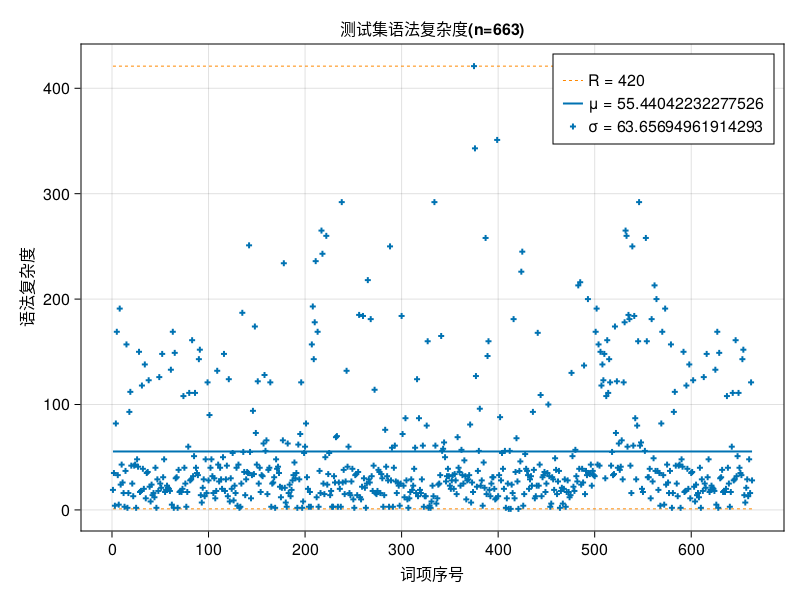

In [21]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度(n=$(size(test_set, 1)))"
ax.xlabel = "词项序号"
ax.ylabel = "语法复杂度"

current_figure()

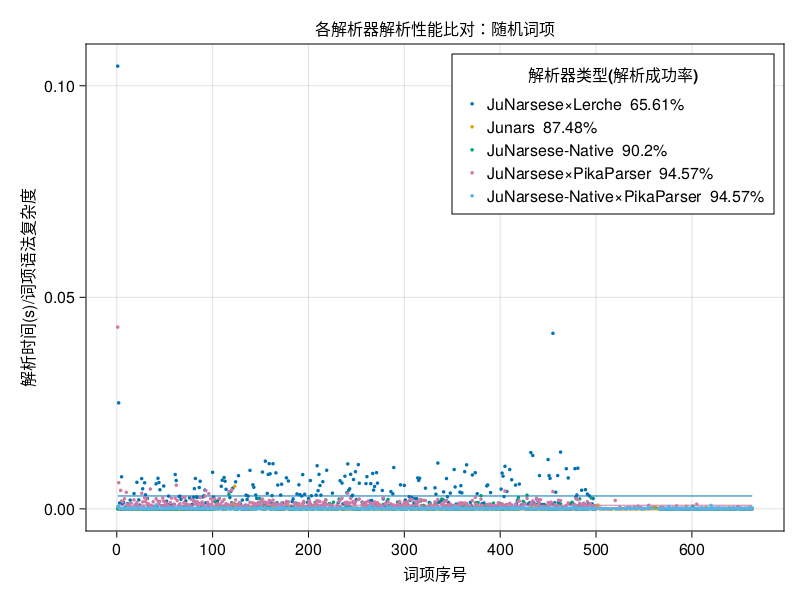

In [22]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

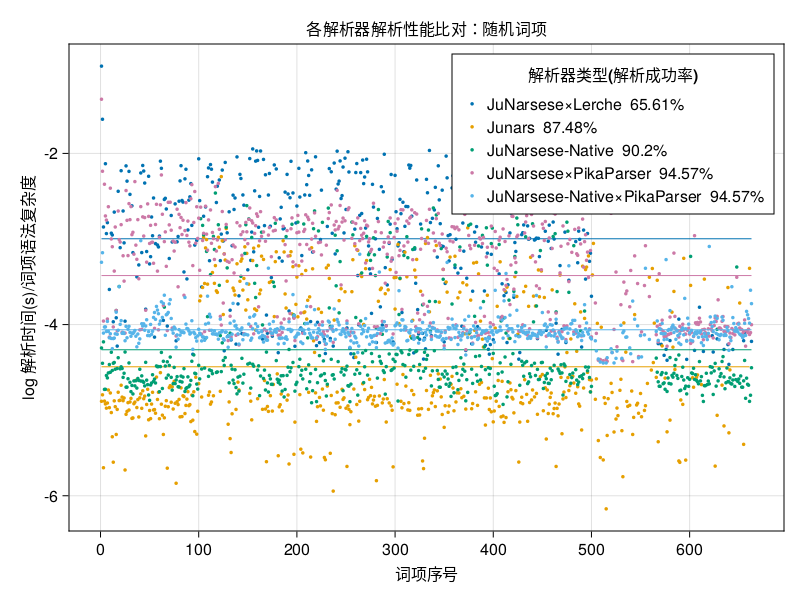

In [23]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项"
ax.xlabel = "词项序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()